In [1]:
%env CUDA_VISIBLE_DEVICES=2

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import copy
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

env: CUDA_VISIBLE_DEVICES=2


In [2]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [3]:
# Load the Data

# Set train and valid directory paths

dataset = 'caltech_10'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')
test_directory = os.path.join(dataset, 'test')

# Batch size
bs = 32

# Number of classes
num_classes = len(os.listdir(valid_directory))-1  #10#2#257
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

10
{0: 'bear', 1: 'chimp', 2: 'giraffe', 3: 'gorilla', 4: 'llama', 5: 'ostrich', 6: 'porcupine', 7: 'skunk', 8: 'triceratops', 9: 'zebra'}


In [4]:
train_data_size, valid_data_size, test_data_size

(600, 100, 409)

In [5]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(pretrained=True)

resnet50 = resnet50.to('cuda:0')

summary(resnet50, input_size=(3, 224, 224))#, batch_size=bs, device='cuda')



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [6]:

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

In [7]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), # Since 10 possible outputs
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

# Convert model to be used on GPU
resnet50 = resnet50.to('cuda:0')


In [8]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())

In [9]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history
    

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print the model to be trained
summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 25 epochs
num_epochs = 30
trained_model, history = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]           4,096
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
           Conv2d-11          [32, 256, 56, 56]          16,384
      BatchNorm2d-12          [32, 256, 56, 56]             512
           Conv2d-13          [32, 256, 56, 56]          16,384
      BatchNorm2d-14          [32, 256,

Batch number: 000, Training: Loss: 2.3123, Accuracy: 0.1562
Batch number: 001, Training: Loss: 2.4084, Accuracy: 0.1250
Batch number: 002, Training: Loss: 2.1393, Accuracy: 0.1875
Batch number: 003, Training: Loss: 2.2488, Accuracy: 0.2812
Batch number: 004, Training: Loss: 2.0986, Accuracy: 0.2812
Batch number: 005, Training: Loss: 1.8768, Accuracy: 0.5312
Batch number: 006, Training: Loss: 1.8295, Accuracy: 0.4062
Batch number: 007, Training: Loss: 1.8742, Accuracy: 0.4375
Batch number: 008, Training: Loss: 1.8058, Accuracy: 0.3750
Batch number: 009, Training: Loss: 1.4476, Accuracy: 0.6875
Batch number: 010, Training: Loss: 1.5858, Accuracy: 0.3750
Batch number: 011, Training: Loss: 1.3597, Accuracy: 0.6875
Batch number: 012, Training: Loss: 1.4875, Accuracy: 0.5312
Batch number: 013, Training: Loss: 1.2558, Accuracy: 0.6562
Batch number: 014, Training: Loss: 1.2537, Accuracy: 0.6562
Batch number: 015, Training: Loss: 1.2137, Accuracy: 0.6562
Batch number: 016, Training: Loss: 1.014

Batch number: 007, Training: Loss: 0.2283, Accuracy: 0.9375
Batch number: 008, Training: Loss: 0.1270, Accuracy: 1.0000
Batch number: 009, Training: Loss: 0.1696, Accuracy: 1.0000
Batch number: 010, Training: Loss: 0.4985, Accuracy: 0.8125
Batch number: 011, Training: Loss: 0.1814, Accuracy: 0.9688
Batch number: 012, Training: Loss: 0.3585, Accuracy: 0.8750
Batch number: 013, Training: Loss: 0.3006, Accuracy: 0.9375
Batch number: 014, Training: Loss: 0.1095, Accuracy: 0.9688
Batch number: 015, Training: Loss: 0.2960, Accuracy: 0.9062
Batch number: 016, Training: Loss: 0.1648, Accuracy: 0.9375
Batch number: 017, Training: Loss: 0.2360, Accuracy: 0.9375
Batch number: 018, Training: Loss: 0.1703, Accuracy: 0.8750
Validation Batch number: 000, Validation: Loss: 0.2366, Accuracy: 0.9375
Validation Batch number: 001, Validation: Loss: 0.3084, Accuracy: 0.9375
Validation Batch number: 002, Validation: Loss: 0.1331, Accuracy: 0.9688
Validation Batch number: 003, Validation: Loss: 0.1675, Accur

Batch number: 014, Training: Loss: 0.1485, Accuracy: 0.9688
Batch number: 015, Training: Loss: 0.0373, Accuracy: 1.0000
Batch number: 016, Training: Loss: 0.1855, Accuracy: 0.9688
Batch number: 017, Training: Loss: 0.0907, Accuracy: 0.9688
Batch number: 018, Training: Loss: 0.1856, Accuracy: 0.9167
Validation Batch number: 000, Validation: Loss: 0.1052, Accuracy: 0.9375
Validation Batch number: 001, Validation: Loss: 0.0864, Accuracy: 1.0000
Validation Batch number: 002, Validation: Loss: 0.2529, Accuracy: 0.9375
Validation Batch number: 003, Validation: Loss: 0.0433, Accuracy: 1.0000
Epoch : 010, Training: Loss: 0.1079, Accuracy: 97.3333%, 
		Validation : Loss : 0.1440, Accuracy: 96.0000%, Time: 7.0651s
Epoch: 12/30
Batch number: 000, Training: Loss: 0.1099, Accuracy: 0.9688
Batch number: 001, Training: Loss: 0.1251, Accuracy: 0.9688
Batch number: 002, Training: Loss: 0.2187, Accuracy: 0.9688
Batch number: 003, Training: Loss: 0.0671, Accuracy: 0.9688
Batch number: 004, Training: Loss

Validation Batch number: 001, Validation: Loss: 0.2136, Accuracy: 0.9375
Validation Batch number: 002, Validation: Loss: 0.1352, Accuracy: 0.9688
Validation Batch number: 003, Validation: Loss: 0.2157, Accuracy: 0.7500
Epoch : 015, Training: Loss: 0.1058, Accuracy: 96.8333%, 
		Validation : Loss : 0.1433, Accuracy: 95.0000%, Time: 7.1467s
Epoch: 17/30
Batch number: 000, Training: Loss: 0.2540, Accuracy: 0.9375
Batch number: 001, Training: Loss: 0.0185, Accuracy: 1.0000
Batch number: 002, Training: Loss: 0.0610, Accuracy: 1.0000
Batch number: 003, Training: Loss: 0.0423, Accuracy: 1.0000
Batch number: 004, Training: Loss: 0.1675, Accuracy: 0.9375
Batch number: 005, Training: Loss: 0.0182, Accuracy: 1.0000
Batch number: 006, Training: Loss: 0.3269, Accuracy: 0.8438
Batch number: 007, Training: Loss: 0.1357, Accuracy: 0.9375
Batch number: 008, Training: Loss: 0.2203, Accuracy: 0.9688
Batch number: 009, Training: Loss: 0.0818, Accuracy: 0.9688
Batch number: 010, Training: Loss: 0.0454, Acc

Batch number: 001, Training: Loss: 0.0510, Accuracy: 1.0000
Batch number: 002, Training: Loss: 0.0678, Accuracy: 1.0000
Batch number: 003, Training: Loss: 0.1166, Accuracy: 0.9688
Batch number: 004, Training: Loss: 0.1074, Accuracy: 0.9688
Batch number: 005, Training: Loss: 0.0227, Accuracy: 1.0000
Batch number: 006, Training: Loss: 0.0117, Accuracy: 1.0000
Batch number: 007, Training: Loss: 0.0516, Accuracy: 1.0000
Batch number: 008, Training: Loss: 0.1620, Accuracy: 0.9375
Batch number: 009, Training: Loss: 0.0428, Accuracy: 1.0000
Batch number: 010, Training: Loss: 0.0474, Accuracy: 0.9688
Batch number: 011, Training: Loss: 0.0162, Accuracy: 1.0000
Batch number: 012, Training: Loss: 0.0576, Accuracy: 0.9688
Batch number: 013, Training: Loss: 0.0398, Accuracy: 1.0000
Batch number: 014, Training: Loss: 0.0409, Accuracy: 1.0000
Batch number: 015, Training: Loss: 0.0335, Accuracy: 1.0000
Batch number: 016, Training: Loss: 0.0307, Accuracy: 1.0000
Batch number: 017, Training: Loss: 0.021

Batch number: 007, Training: Loss: 0.0468, Accuracy: 1.0000
Batch number: 008, Training: Loss: 0.0498, Accuracy: 1.0000
Batch number: 009, Training: Loss: 0.0435, Accuracy: 0.9688
Batch number: 010, Training: Loss: 0.0870, Accuracy: 0.9688
Batch number: 011, Training: Loss: 0.1842, Accuracy: 0.9688
Batch number: 012, Training: Loss: 0.0696, Accuracy: 0.9688
Batch number: 013, Training: Loss: 0.0575, Accuracy: 1.0000
Batch number: 014, Training: Loss: 0.0217, Accuracy: 1.0000
Batch number: 015, Training: Loss: 0.1011, Accuracy: 0.9375
Batch number: 016, Training: Loss: 0.0154, Accuracy: 1.0000
Batch number: 017, Training: Loss: 0.0444, Accuracy: 1.0000
Batch number: 018, Training: Loss: 0.0102, Accuracy: 1.0000
Validation Batch number: 000, Validation: Loss: 0.1548, Accuracy: 0.9688
Validation Batch number: 001, Validation: Loss: 0.2240, Accuracy: 0.9375
Validation Batch number: 002, Validation: Loss: 0.0284, Accuracy: 0.9688
Validation Batch number: 003, Validation: Loss: 0.0016, Accur

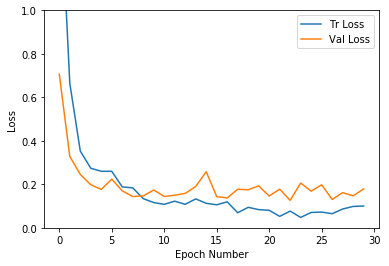

In [12]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()


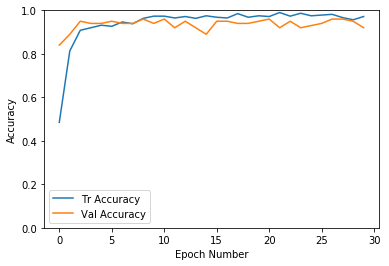

In [13]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [15]:
 def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))


In [61]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(3, dim=1)
        for i in range(3):
            print("Predcition", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])




Predcition 1 : triceratops , Score:  0.993689
Predcition 2 : chimp , Score:  0.003457127
Predcition 3 : zebra , Score:  0.0012487078


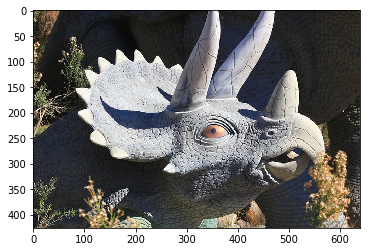

In [75]:
# Test a particular model on a test image

dataset = 'caltech_10'
model = torch.load('caltech_10_model_8.pt')
predict(model, 'pixabay-test-animals/triceratops-954293_640.jpg')

# Load Data from folders
#computeTestSetAccuracy(model, loss_func)
        
        